
Branin: 2D


In [ ]:
pip install pyGPGO


In [ ]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dERM_GP'
util_grad_approx = 'ExpectedRegret'

n_init = 5 # random initialisations
iters = 20
opt = True

In [ ]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [ ]:
n_start_AcqFunc = iters


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [ ]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedRegret': self.ExpectedRegret,
            'dERM_GP': self.dERM_GP
        }

        self.f = mode_dict[mode]
    
    def ExpectedRegret(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (mean - y_global_orig) * norm.cdf(z) + std * norm.pdf(z)[0]


    def dERM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [ ]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [ ]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
start_approx = time.time()
start_approx


1637144629.9423244

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [ 8.98893195 10.45227242]. 	  -70.52424256621515 	 -5.089934878453152
3      	 [-3.93920149 13.25441417]. 	  -4.333308116197517 	 -4.333308116197517
4      	 [3.29585328 0.        ]. 	  -5.167890908848676 	 -4.333308116197517
5      	 [ 5.36701892 15.        ]. 	  -206.8589766877631 	 -4.333308116197517
6      	 [5.81444645 5.67080203]. 	  -39.335751165739254 	 -4.333308116197517
7      	 [-5.          9.41518323]. 	  -73.13048618123008 	 -4.33330811619751

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [ 9.5587047  12.00387527]. 	  -89.09951357262268 	 -6.692051508754487
2      	 [9.59366035 1.69164323]. 	  -1.3984593420568778 	 -1.3984593420568778
3      	 [ 2.76755193 13.40050896]. 	  -118.04193885354222 	 -1.3984593420568778
4      	 [-5.          0.73986183]. 	  -283.24394841613446 	 -1.3984593420568778
5      	 [-3.14464907 14.56432333]. 	  -5.605350427804851 	 -1.3984593420568778
6      	 [8.93672669 6.44382594]. 	  -20.439158338984655 	 -1.3984593420568778
7      	 [-5.          6.09195487]. 	  -135.83176862127195 	 -1.3984593

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-3.89564496 13.38589781]. 	  -3.6010193697779265 	 -3.6010193697779265
3      	 [2.67993826 0.82315258]. 	  -4.786478981860064 	 -3.6010193697779265
4      	 [10.  0.]. 	  -10.960889035651505 	 -3.6010193697779265
5      	 [ 0.48224098 15.        ]. 	  -113.32534391424977 	 -3.6010193697779265
6      	 [10.          8.34455279]. 	  -30.47579050396284 	 -3.6010193697779265
7      	 [6.14184152 0.24227011]. 	  -20.2387699483704 	 -3.6010193697779265
8      

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 1.25164457 13.57001383]. 	  -100.61648848019335 	 -7.247126865776948
2      	 [0.47714304 0.        ]. 	  -46.30270712048601 	 -7.247126865776948
3      	 [-5.        10.4721139]. 	  -57.81828491041938 	 -7.247126865776948
4      	 [-4.88521651  1.98881641]. 	  -232.74673062582045 	 -7.247126865776948
5      	 [3.92795196 8.48388558]. 	  -48.67477858971573 	 -7.247126865776948
6      	 [ 6.50636809 15.        ]. 	  -212.19776277207015 	 -7.247126865776948
7      	 [1.67655135 4.0775761 ]. 	  -9.132937223241916 	 -7.247126865776948
8   

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [ 8.39476442 14.47736321]. 	  -167.21523769473345 	 -5.96108856337545
3      	 [-5.          8.52071661]. 	  -87.83446181212865 	 -5.96108856337545
4      	 [-5.  0.]. 	  -308.12909601160663 	 -5.96108856337545
5      	 [3.88784136 0.        ]. 	  -6.06486474045351 	 -5.96108856337545
6      	 [ 3.02988302 15.        ]. 	  -160.1330600826706 	 -5.96108856337545
7      	 [10.          4.33638034]. 	  -3.721159508797653 	 -3.721159508797653
8      	 [3.8013

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [ 9.64829531 12.55362889]. 	  -98.32295673962142 	 -15.31731051317483
2      	 [-1.82404332  0.        ]. 	  -94.69665209951235 	 -15.31731051317483
3      	 [-5. 15.]. 	  -17.508299515778166 	 -15.31731051317483
4      	 [ 2.93119716 15.        ]. 	  -158.24274224443167 	 -15.31731051317483
5      	 [-5.          4.22937653]. 	  -180.63308889086397 	 -15.31731051317483
6      	 [ 5.17635766 10.29129859]. 	  -96.53047826357314 	 -15.31731051317483
7      	 [2.86396934 1.5860754 ]. 	  -1.6034929380337442 	 -1.6034929380337442
8      	 [-1

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [-4.97859679  1.38393519]. 	  -260.3293952774437 	 -5.211335324193094
2      	 [ 7.42679792 14.12713902]. 	  -178.37635728719692 	 -5.211335324193094
3      	 [8.08940775 0.35854539]. 	  -9.249625108410735 	 -5.211335324193094
4      	 [-3.39684884  5.54228873]. 	  -54.79871094423047 	 -5.211335324193094
5      	 [4.4720934  5.93920773]. 	  -27.723638017330405 	 -5.211335324193094
6      	 [-0.88698611 15.        ]. 	  -72.11656179914581 	 -5.211335324193094
7      	 [10.          3.80989492]. 	  -2.5942901078331397 	 -2.5942901078331

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [9.77124156 0.43098073]. 	  -6.499298445992174 	 -6.499298445992174
2      	 [-4.87537438 11.82874897]. 	  -36.57081146531108 	 -6.499298445992174
3      	 [-5.          6.18626546]. 	  -133.74783473476617 	 -6.499298445992174
4      	 [ 2.00490905 12.66503403]. 	  -93.13466791376042 	 -6.499298445992174
5      	 [4.49710607 1.43886209]. 	  -7.949028807737028 	 -6.499298445992174
6      	 [-1.26517273  9.27145837]. 	  -13.993955682370324 	 -6.499298445992174
7      	 [-1.94955274 15.        ]. 	  -35.676380167837124 	 -6.4992984459

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [-0.46054038 14.56197292]. 	  -79.4666617606301 	 -3.4640248583909496
3      	 [8.28747407 1.2035024 ]. 	  -6.196385269800155 	 -3.4640248583909496
4      	 [5.09988923 9.09295299]. 	  -75.24675017972764 	 -3.4640248583909496
5      	 [10.          6.16249821]. 	  -11.925843837802418 	 -3.4640248583909496
6      	 [4.22157467e-05 9.30120175e+00]. 	  -30.50048925898127 	 -3.4640248583909496
7      	 [-5.         12.67802287]. 	  -33.0578765236372 	 -3.

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [ 9.16391068 14.81438212]. 	  -158.2412724465548 	 -2.710610964564512
2      	 [9.65621089 6.61160737]. 	  -16.1339423373336 	 -2.710610964564512
3      	 [-3.43070383  6.59407857]. 	  -41.58407101130534 	 -2.710610964564512
4      	 [-5.         14.87293215]. 	  -18.080332001739464 	 -2.710610964564512
5      	 [ 0.92449322 15.        ]. 	  -123.13234915138221 	 -2.710610964564512
6      	 [1.30728865 7.43276202]. 	  -23.342263281989574 	 -2.710610964564512
7      	 [5.49073155 5.83993012]. 	  -38.681772916454804 	 -2.710610964564512

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [6.94653631 0.95529646]. 	  -17.615403152614682 	 -17.615403152614682
2      	 [9.95799301 6.93425723]. 	  -17.51361722617643 	 -17.51361722617643
3      	 [-2.04991594 15.        ]. 	  -32.5573558333363 	 -17.51361722617643
4      	 [2.40807729 2.49081214]. 	  -3.048554877803756 	 -3.048554877803756
5      	 [ 4.54021213 15.        ]. 	  -192.31050872160282 	 -3.048554877803756
6      	 [5.61068086 5.52610486]. 	  -36.77546338781394 	 -3.048554877803756
7      	 [-5.         11.91405806]. 	  -40.5314683386421 	 -3.048554877803756
8

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [10.          4.44128644]. 	  -4.011933380719501 	 -0.5499315281120278
2      	 [ 8.50155249 13.79797306]. 	  -148.00655208378976 	 -0.5499315281120278
3      	 [-4.8799499   0.15657603]. 	  -290.0404981832191 	 -0.5499315281120278
4      	 [4.4336702  8.80667229]. 	  -60.99395871160691 	 -0.5499315281120278
5      	 [3.16173281 0.58781787]. 	  -3.1938407385388565 	 -0.5499315281120278
6      	 [ 1.68953656 13.94416005]. 	  -114.2200057097559 	 -0.5499315281120278
7      	 [-0.39788844  3.26316746]. 	  -30.347792772205334 	 -0.5

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-3.51870171  3.68338658]. 	  -91.63196166423945 	 -18.038943061558626
2      	 [-3.06562888 11.40851515]. 	  -0.8943531028899869 	 -0.8943531028899869
3      	 [2.3685613 0.       ]. 	  -11.859175693404021 	 -0.8943531028899869
4      	 [1.73680198 5.92713917]. 	  -13.710957542040685 	 -0.8943531028899869
5      	 [-0.26301224 15.        ]. 	  -92.75909151223124 	 -0.8943531028899869
6      	 [10.  0.]. 	  -10.960889035651505 	 -0.8943531028899869
7      	 [-5. 15.]. 	  -17.508299515778166 	 -0.8943531028899869
8      	 [-0.223

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-5.  0.]. 	  -308.1290960116068 	 -1.4149920024014744
2      	 [-3.61083748  7.85924032]. 	  -32.481990179851884 	 -1.4149920024014744
3      	 [8.4415984  6.61360555]. 	  -28.132050221972662 	 -1.4149920024014744
4      	 [0.61707243 0.        ]. 	  -43.506647353554065 	 -1.4149920024014744
5      	 [ 9.81482319 14.16972583]. 	  -129.85218172547337 	 -1.4149920024014744
6      	 [-5. 15.]. 	  -17.508299515778166 	 -1.4149920024014744
7      	 [ 5.3572922 15.       ]. 	  -206.7291945187916 	 -1.4149920024014744
8      	 [-1.6001112

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [ 6.5655417  11.87699252]. 	  -134.95011349993544 	 -12.768724532005583
2      	 [-4.77493765 13.49591113]. 	  -19.896906503438096 	 -12.768724532005583
3      	 [ 0.49807252 15.        ]. 	  -113.70597669512716 	 -12.768724532005583
4      	 [2.5472886 0.       ]. 	  -9.795500118061007 	 -9.795500118061007
5      	 [10.          7.39573963]. 	  -21.239683331520574 	 -9.795500118061007
6      	 [4.44361813 6.68446945]. 	  -34.551204730283004 	 -9.795500118061007
7      	 [ 2.13180408 10.67402786]. 	  -60.838836699892866 	 -9.7

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [10.          9.72351059]. 	  -47.108986579541174 	 -2.715864006988424
3      	 [4.24604327 7.89508499]. 	  -45.673350938361665 	 -2.715864006988424
4      	 [-5.          2.46874265]. 	  -229.36144957428314 	 -2.715864006988424
5      	 [10.  0.]. 	  -10.960889035651505 	 -2.715864006988424
6      	 [ 0.5294212 12.4046176]. 	  -70.28622813394162 	 -2.715864006988424
7      	 [10.          4.71265256]. 	  -4.866200912762386 	 -2.715864006988424
8      	 [10.

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [9.76575296 0.98553483]. 	  -4.1623278326263815 	 -4.1623278326263815
2      	 [-0.36591853 14.49945231]. 	  -81.3728947682288 	 -4.1623278326263815
3      	 [3.74599703 2.35814314]. 	  -2.3563457989420957 	 -2.3563457989420957
4      	 [10.         14.64086749]. 	  -137.38411051487694 	 -2.3563457989420957
5      	 [-5.         11.17262384]. 	  -48.90080592714383 	 -2.3563457989420957
6      	 [10.          5.64908461]. 	  -8.945134101750817 	 -2.3563457989420957
7      	 [6.38336468 4.48266709]. 	  -30.966082230959298 	 -2.3563

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-1.52468598  7.08270423]. 	  -13.146058885158528 	 -8.150075223157177
3      	 [ 0.43344746 11.75516361]. 	  -59.940118096716546 	 -8.150075223157177
4      	 [4.16808622 0.        ]. 	  -7.621849182200764 	 -7.621849182200764
5      	 [3.25051177 4.09052476]. 	  -4.0607372492488985 	 -4.0607372492488985
6      	 [-5.          3.80328804]. 	  -191.85713523908967 	 -4.0607372492488985
7      	 [10.          6.76719706]. 	  -16.112646836437207 	 -4.06073724

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [9.57054653 2.03489665]. 	  -0.8198597583535783 	 -0.8198597583535783
2      	 [4.40529125 4.87644674]. 	  -18.52616991036314 	 -0.8198597583535783
3      	 [-5.          6.34895594]. 	  -130.19475625502412 	 -0.8198597583535783
4      	 [ 0.06514599 15.        ]. 	  -102.44880734859521 	 -0.8198597583535783
5      	 [10. 15.]. 	  -145.87219087939556 	 -0.8198597583535783
6      	 [0.56335389 8.5053089 ]. 	  -29.414039626479212 	 -0.8198597583535783
7      	 [5.44748404 0.        ]. 	  -17.793743915872703 	 -0.8198597583535783
8     

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-0.18867118  0.75465687]. 	  -50.23667197430394 	 -14.042667401507376
2      	 [10.         5.9079623]. 	  -10.382198762189898 	 -10.382198762189898
3      	 [-5.          3.81449004]. 	  -191.5574040002248 	 -10.382198762189898
4      	 [-0.52181708 12.89618994]. 	  -54.69134022398591 	 -10.382198762189898
5      	 [5.58659234 7.78970481]. 	  -61.57689219668029 	 -10.382198762189898
6      	 [9.52692193 0.        ]. 	  -7.01438462309541 	 -7.01438462309541
7      	 [-5. 15.]. 	  -17.508299515778166 	 -7.01438462309541
8      	

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1637144793.2002194

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [ 8.98893195 10.45227242]. 	  -70.52424256621515 	 -5.089934878453152
3      	 [3.38718802 0.        ]. 	  -5.0593980998135075 	 -5.0593980998135075
4      	 [-4.67712792 14.21955317]. 	  -13.865244792739254 	 -5.0593980998135075
5      	 [4.42114297 4.28364423]. 	  -15.054851223732111 	 -5.0593980998135075
6      	 [-4.390766    9.66380875]. 	  -40.77704906098703 	 -5.0593980998135075
7      	 [ 4.549066   14.90869537]. 	  -190.02550896454528 	 -5.0593980

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [ 9.5587047  12.00387527]. 	  -89.09951357262268 	 -6.692051508754487
2      	 [9.59366035 1.69164323]. 	  -1.3984593420568778 	 -1.3984593420568778
3      	 [ 3.24245232 12.67669673]. 	  -110.25694222671481 	 -1.3984593420568778
4      	 [-5.  0.]. 	  -308.12909601160663 	 -1.3984593420568778
5      	 [-5.          5.77963107]. 	  -142.8600329551978 	 -1.3984593420568778
6      	 [-3.95509114 14.02730345]. 	  -3.48680055844817 	 -1.3984593420568778
7      	 [6.07997041 0.        ]. 	  -20.61203534900828 	 -1.3984593420568778
8      	 

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-3.89564496 13.38589781]. 	  -3.6010193697779265 	 -3.6010193697779265
3      	 [1.81549557 3.88378641]. 	  -7.794464644280723 	 -3.6010193697779265
4      	 [4.52510097 0.        ]. 	  -10.295335207846547 	 -3.6010193697779265
5      	 [7.30433025 8.82548091]. 	  -72.14351396080065 	 -3.6010193697779265
6      	 [9.93672163 0.73577203]. 	  -6.49061146894648 	 -3.6010193697779265
7      	 [ 0.7273756  14.67607729]. 	  -112.53473754745858 	 -3.601019369777

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 1.25164457 13.57001383]. 	  -100.61648848019335 	 -7.247126865776948
2      	 [-4.27198795  1.64727177]. 	  -188.41076037632916 	 -7.247126865776948
3      	 [1.24886104 0.        ]. 	  -30.794745512786793 	 -7.247126865776948
4      	 [3.06500715 8.82989275]. 	  -42.603383320434965 	 -7.247126865776948
5      	 [-4.73699493 13.33053872]. 	  -19.892240270122997 	 -7.247126865776948
6      	 [-5.          7.74203423]. 	  -101.93793286086269 	 -7.247126865776948
7      	 [ 7.15995113 14.45073253]. 	  -191.00332078453908 	 -7.247126865776

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [ 8.39476442 14.47736321]. 	  -167.21523769473345 	 -5.96108856337545
3      	 [-3.98474739  8.11668752]. 	  -43.007409247434076 	 -5.96108856337545
4      	 [-5.  0.]. 	  -308.12909601160663 	 -5.96108856337545
5      	 [4.61112248 2.57446817]. 	  -10.390053653436548 	 -5.96108856337545
6      	 [1.92360986 0.        ]. 	  -18.354550502133165 	 -5.96108856337545
7      	 [ 2.56483621 13.11275581]. 	  -108.97006652165066 	 -5.96108856337545
8      	 [8.73

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [ 9.64829531 12.55362889]. 	  -98.32295673962142 	 -15.31731051317483
2      	 [-1.22578785  0.62063252]. 	  -69.8637190838968 	 -15.31731051317483
3      	 [ 4.34724927 14.59608757]. 	  -177.48889452505895 	 -15.31731051317483
4      	 [-5.          4.21034228]. 	  -181.1267421699523 	 -15.31731051317483
5      	 [6.97224117 8.73076067]. 	  -74.37597568481661 	 -15.31731051317483
6      	 [-2.88144405 14.07252479]. 	  -6.548287566158158 	 -6.548287566158158
7      	 [3.23249588 0.        ]. 	  -5.30033331869239 	 -5.30033331869239
8    

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [-5.          2.65190826]. 	  -224.0031100533308 	 -5.211335324193094
2      	 [ 7.42679792 14.12713902]. 	  -178.37635728719692 	 -5.211335324193094
3      	 [8.08940775 0.35854539]. 	  -9.249625108410735 	 -5.211335324193094
4      	 [-3.39684884  5.54228873]. 	  -54.79871094423047 	 -5.211335324193094
5      	 [4.93106932 5.49280768]. 	  -29.72032114718932 	 -5.211335324193094
6      	 [-1.18248519  0.        ]. 	  -78.64142677081142 	 -5.211335324193094
7      	 [ 0.41036662 14.84871201]. 	  -108.67673451031358 	 -5.21133532419309

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [9.77124156 0.43098073]. 	  -6.499298445992174 	 -6.499298445992174
2      	 [-4.87537438 11.82874897]. 	  -36.57081146531108 	 -6.499298445992174
3      	 [-4.45701815  6.26711165]. 	  -95.79736776302217 	 -6.499298445992174
4      	 [4.54610188 0.93996897]. 	  -8.655217490029118 	 -6.499298445992174
5      	 [-0.10664759 12.3093941 ]. 	  -57.22493359528667 	 -6.499298445992174
6      	 [7.40087489 3.51127056]. 	  -19.106608006620732 	 -6.499298445992174
7      	 [ 4.79164746 10.26335952]. 	  -90.3880656137853 	 -6.499298445992174

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [-0.46054038 14.56197292]. 	  -79.4666617606301 	 -3.4640248583909496
3      	 [8.28747407 1.2035024 ]. 	  -6.196385269800155 	 -3.4640248583909496
4      	 [4.74860988 9.34294938]. 	  -74.1491079038336 	 -3.4640248583909496
5      	 [9.67993735 5.53971063]. 	  -8.780439004071868 	 -3.4640248583909496
6      	 [5.69614675 4.2958879 ]. 	  -28.043820974801463 	 -3.4640248583909496
7      	 [0.42414727 7.74400067]. 	  -24.491182719292794 	 -3.46402485839

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [ 9.16391068 14.81438212]. 	  -158.2412724465548 	 -2.710610964564512
2      	 [9.65621089 6.61160737]. 	  -16.1339423373336 	 -2.710610964564512
3      	 [-3.43070383  6.59407857]. 	  -41.584071053022164 	 -2.710610964564512
4      	 [0.96274719 8.01363279]. 	  -27.223902729168035 	 -2.710610964564512
5      	 [5.28809946 6.22346071]. 	  -40.50060051055487 	 -2.710610964564512
6      	 [2.03789631 0.        ]. 	  -16.520643618334798 	 -2.710610964564512
7      	 [-5.          9.81287724]. 	  -67.1067505709128 	 -2.710610964564512
8  

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [6.94653631 0.95529646]. 	  -17.615403152614682 	 -17.615403152614682
2      	 [7.49824569 7.26709445]. 	  -48.60043130614873 	 -17.615403152614682
3      	 [2.42708472 2.24786382]. 	  -3.169307171991125 	 -3.169307171991125
4      	 [-0.61006551  4.0649659 ]. 	  -26.596482779337297 	 -3.169307171991125
5      	 [-3.42208896 11.32925449]. 	  -3.4300860679630905 	 -3.169307171991125
6      	 [-5.          3.03362246]. 	  -213.05203933468084 	 -3.169307171991125
7      	 [-0.77255064 14.09983832]. 	  -63.023736455229056 	 -3.169307171

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [9.43895355 6.28875405]. 	  -14.852312468115107 	 -0.5499315281120278
2      	 [ 5.04936449 13.86496049]. 	  -172.12573102553992 	 -0.5499315281120278
3      	 [-4.56313632  0.        ]. 	  -263.050103585265 	 -0.5499315281120278
4      	 [3.20516942 0.45821173]. 	  -3.542154334189336 	 -0.5499315281120278
5      	 [4.20804395 8.14007051]. 	  -48.260184648260896 	 -0.5499315281120278
6      	 [-5.         5.4160296]. 	  -151.28797294097743 	 -0.5499315281120278
7      	 [ 9.98185613 14.45397276]. 	  -133.3870781696882 	 -0.54993

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-3.51870171  3.68338658]. 	  -91.63196166423945 	 -18.038943061558626
2      	 [-3.06562888 11.40851515]. 	  -0.8943531028899869 	 -0.8943531028899869
3      	 [2.50126004 0.        ]. 	  -10.293935734443487 	 -0.8943531028899869
4      	 [1.77403168 5.06045191]. 	  -10.244460220886948 	 -0.8943531028899869
5      	 [8.57494485 0.        ]. 	  -7.089419329860927 	 -0.8943531028899869
6      	 [-0.41766712  8.86639134]. 	  -23.52524736032078 	 -0.8943531028899869
7      	 [-5.          8.28447684]. 	  -91.98508281441575 	 -0.894

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-4.22572169  4.73878507]. 	  -111.46482334173054 	 -1.4149920024014744
2      	 [ 9.02510452 14.92575454]. 	  -164.15736583327134 	 -1.4149920024014744
3      	 [8.4415984  6.61360555]. 	  -28.132050221972662 	 -1.4149920024014744
4      	 [-0.28129203  0.        ]. 	  -60.92935277649973 	 -1.4149920024014744
5      	 [-2.50407204  9.50550211]. 	  -3.947802937246821 	 -1.4149920024014744
6      	 [-5.  0.]. 	  -308.12909601160663 	 -1.4149920024014744
7      	 [ 7.00823659 10.77355664]. 	  -109.01240733833406 	 -1.4149920024014744


In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [ 6.5655417  11.87699252]. 	  -134.95011349993544 	 -12.768724532005583
2      	 [-4.77493765 13.49591113]. 	  -19.896906503438096 	 -12.768724532005583
3      	 [3.02212362 0.        ]. 	  -6.083291596856743 	 -6.083291596856743
4      	 [4.35171178 6.82765368]. 	  -34.77770964446557 	 -6.083291596856743
5      	 [-0.95276022  0.        ]. 	  -73.83615148837168 	 -6.083291596856743
6      	 [ 0.88141399 12.8616488 ]. 	  -82.76006345674953 	 -6.083291596856743
7      	 [9.8673558  5.57328662]. 	  -8.611202245125636 	 -6.083291

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [9.4202829  9.76772141]. 	  -53.637049482645274 	 -2.715864006988424
3      	 [-5.          2.97904462]. 	  -214.599978788139 	 -2.715864006988424
4      	 [3.94595588 8.63361763]. 	  -50.9823562707124 	 -2.715864006988424
5      	 [-5.         10.25045351]. 	  -60.84442629231879 	 -2.715864006988424
6      	 [ 0.37481671 13.2972156 ]. 	  -80.96065502264867 	 -2.715864006988424
7      	 [9.25810749 0.8143285 ]. 	  -2.8525180892544473 	 -2.715864006988424
8  

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [9.76575296 0.98553483]. 	  -4.1623278326263815 	 -4.1623278326263815
2      	 [-0.36591853 14.49945231]. 	  -81.3728947682288 	 -4.1623278326263815
3      	 [3.74599703 2.35814314]. 	  -2.3563457989420957 	 -2.3563457989420957
4      	 [-4.55592013 10.78104721]. 	  -35.03990542982294 	 -2.3563457989420957
5      	 [ 4.90329936 14.65548099]. 	  -190.13600881699344 	 -2.3563457989420957
6      	 [0.90202099 4.10045519]. 	  -16.277366428872963 	 -2.3563457989420957
7      	 [7.03357696 4.77025982]. 	  -29.794040014128484 	 -2.35634

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-0.81273809  6.75772231]. 	  -16.987367428186804 	 -8.150075223157177
3      	 [-5.          1.59202772]. 	  -255.93814160760837 	 -8.150075223157177
4      	 [4.09807515 0.        ]. 	  -7.178840366251819 	 -7.178840366251819
5      	 [-0.12756076 10.65515995]. 	  -39.32694072921518 	 -7.178840366251819
6      	 [-4.9478767   6.19692083]. 	  -129.75673551258598 	 -7.178840366251819
7      	 [3.63433759 3.53328753]. 	  -4.136121365909651 	 -4.136121365909

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [9.57054653 2.03489665]. 	  -0.8198597583535783 	 -0.8198597583535783
2      	 [-5.          6.54240853]. 	  -126.03874562590048 	 -0.8198597583535783
3      	 [1.88138812 7.36103219]. 	  -22.260488293127565 	 -0.8198597583535783
4      	 [5.21307192 0.        ]. 	  -16.082736923380203 	 -0.8198597583535783
5      	 [6.89304699 4.9685997 ]. 	  -32.319774400947445 	 -0.8198597583535783
6      	 [ 0.31300644 13.28548082]. 	  -79.52384335078895 	 -0.8198597583535783
7      	 [-5.  0.]. 	  -308.12909601160663 	 -0.8198597583535783
8     

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-0.55245589  2.17087824]. 	  -40.71539242209087 	 -14.042667401507376
2      	 [7.53979655 6.90105923]. 	  -43.84846144433857 	 -14.042667401507376
3      	 [-5.  0.]. 	  -308.12909601160663 	 -14.042667401507376
4      	 [-4.04599663  5.55984253]. 	  -84.96225972165362 	 -14.042667401507376
5      	 [-1.8272025  14.05429763]. 	  -29.795226417857446 	 -14.042667401507376
6      	 [8.57377587 0.20539103]. 	  -6.3770995162900785 	 -6.3770995162900785
7      	 [2.78616162 0.        ]. 	  -7.595276359645523 	 -6.3770995162900785
8 

In [ ]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

643.4609100818634

In [ ]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(1.3700178942367358, -1.3756284297896297)

In [ ]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(0.0005721783316311656, -1.9490131153703354)

In [ ]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(0.588697756495755, 1.164129196584808)

In [ ]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(0.9093022047308048, 1.3793515010391477)

In [ ]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.2009499928706422, -0.11800119797963454)

In [ ]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(0.18698229369438288, -3.5815307805908434)

In [ ]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.786821071388407, -0.28124602626130507)

In [ ]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.0741475700758296, 1.8085201290028612)

In [ ]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.4530317897890098, 1.7575989650270891)

In [ ]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.6062684931422699, 0.7440582239416507)

In [ ]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.4375408915546775, 0.9010367961576701)

In [ ]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.415680339000338, 1.1455809009105582)

In [ ]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-0.7002400699524578, -4.999903128444473)

In [ ]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-0.6986099945532999, 0.6985046848441511)

In [ ]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.7616318484426097, 0.5190611646945158)

In [ ]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.828857760742628, 0.011796845272393301)

In [ ]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.4428317908712237, 0.3736586777309275)

In [ ]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.298241600965053, 0.9452449170607248)

In [ ]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-2.8682732586079323, -0.8628145206943092)

In [ ]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(1.666641011087512, -1.593649710027912)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [ ]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

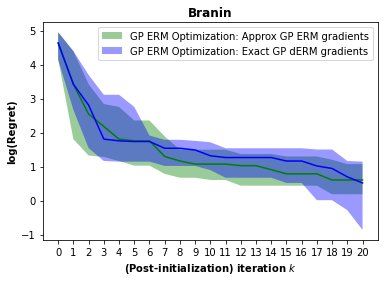

In [103]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM Optimization: Approx GP ERM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP ERM Optimization: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [ ]:
time_approx, time_exact


(163.2577896118164, 643.4609100818634)